<h1>IMPORT LIBRARY</h1>

In [1]:
from datasets import load_dataset
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2
from evaluate import load
from transformers import AutoImageProcessor
import numpy as np
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch
import wandb
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

/home/a_syarif_hidayat/anaconda3/envs/trash_class/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Data Preparation</h1>

In [2]:
model_checkpoint = 'google/vit-base-patch16-224'
batch_size = 8
lr = 5e-4
epochs = 3

Saya menggunakan model <b>ViT</b> untuk fine tuning, karena model ini cepat dalam memproses image dan arsitekturnya efisien

In [3]:
ds = load_dataset("garythung/trashnet")

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})

In [5]:
#Dataset Features
ds['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], id=None)}

0 = Cardboard <br>
1 = Glass <br>
2 = Metal <br>
3 = Paper <br>
4 = Plastic <br>
5 = Trash

In [6]:
metric = load("accuracy")

In [7]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

<h1>Exploratory Image Analysis</h1>

In [8]:
#Load images from the dataset (train split)
train_images = ds['train']

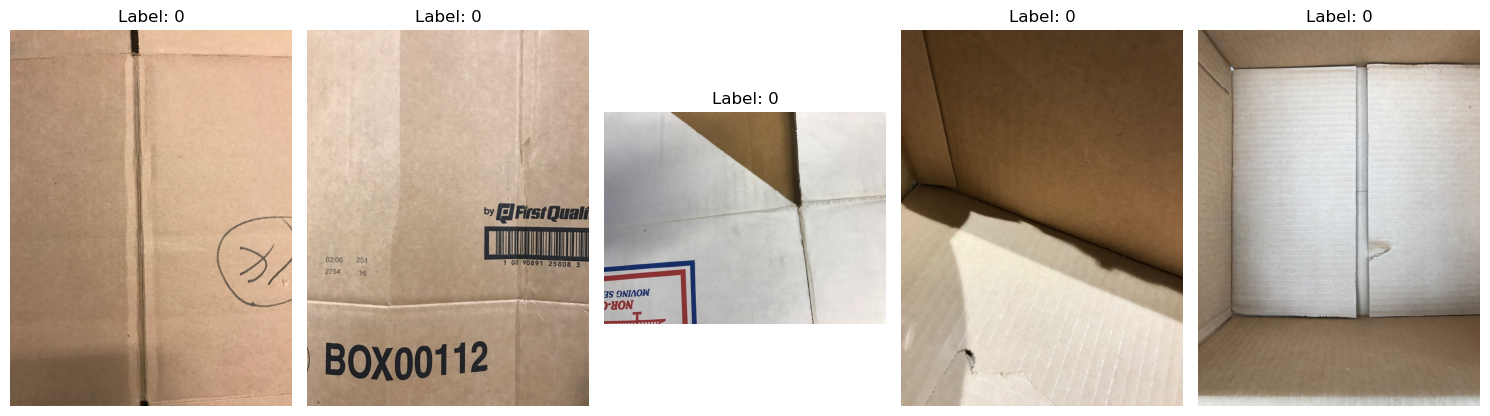

In [9]:
#Show Random Image in Dataset
def show_random_image(ds, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        image_data = ds[i]
        image = image_data['image']
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"Label: {image_data['label']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_random_image(train_images)

In [10]:
#Analyze distribution of image labels
labels = [sample['label'] for sample in train_images]
label_counts = Counter(labels)

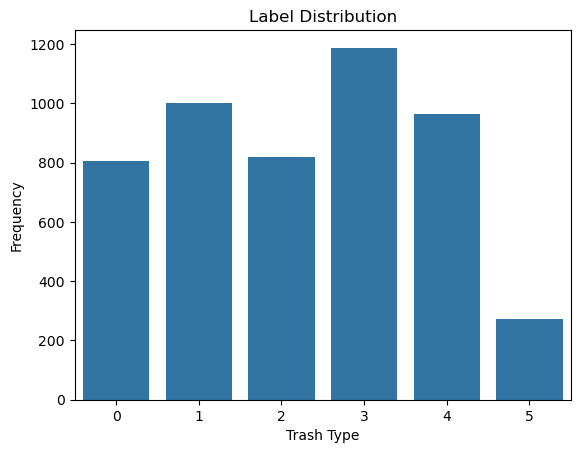

In [11]:
#Plot the label distribution
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Label Distribution")
plt.xlabel("Trash Type")
plt.ylabel("Frequency")
plt.show()

Dapat kita ketahui bahwa <b>kelas 3 (Paper)</b> memiliki jumlah data paling banyak dan <b>kelas 5 (Trash)</b> memiliki data paling sedikit, ini menunjukkan bahwa dataset tersebut mengalami <i><b>class imbalance</b></i>. Ini dapat mempengaruhi performance model karena model mungkin akan lebih cenderung memprediksi kelas paling banyak

<h1>Data Pre-processing</h1>

In [12]:
#Load image processor
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [13]:
#Define height and width
if "height" in image_processor.size:
    height = image_processor.size["height"]
    width = image_processor.size["width"]

#Data Augmentation
train_transform = A.Compose([
    A.Resize(height=height, width=width),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Affine(shear=(-20, 20), p=1.0, interpolation=cv2.INTER_NEAREST),
    A.Normalize(),
    A.CLAHE(clip_limit=4, p=1.0),
    A.VerticalFlip(p=1.0),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=height, width=width),
    A.Normalize(),
    ToTensorV2()
])

#Preprocessing functions
def preprocess_train(examples):
    examples["pixel_values"] = [
        train_transform(image=np.array(image))["image"] for image in examples["image"]
    ]
    return examples

def preprocess_val(examples):
    examples["pixel_values"] = [
        val_transform(image=np.array(image))["image"] for image in examples["image"]
    ]
    return examples

- Saya menggunakan <b>Resize</b> untuk mengubah ukuran gambar agar sesuai dengan input model yang saya pakai
- Saya menggunakan <b>HotizontalFlip</b>, <b>Rotate</b>, <b>Affine</b> dan <b>VerticalFlip</b> untuk menambah variasi gambar dan membuat model lebih toleran terhadap berbagai variasi gambar
- Saya menggunakan <b>CLAHE</b> untuk meningkatkan kontras pada gambar, ini berguna untuk gambar yang kurang terang
- Saya menggunakan <b>Normalize</b> untuk membuat piksel gambar memiliki rata-rata 0 dan standar deviasi 1, ini dapat mempercepat konvergensi pelatihan

<b>Justifikasi</b></br>
Data augmentation dilakukan untuk meningkatkan generalisasi model, sehingga model tidak hanya belajar dari pola yang spesifik pada data pelatihan, tetapi juga dapat mengenali variasi di data dunia nyata.

<b>Kelebihan</b>
- Meningkatkan variasi dataset tanpa memerlukan data tambahan.
- Membantu model menjadi lebih tangguh (robust) terhadap noise atau variasi.

<b>Kekurangan</b></br>
Augmentasi berlebihan dapat memperkenalkan noise yang tidak realistis, yang dapat membingungkan model jika tidak dikontrol dengan benar.

In [14]:
#Split up training into training + validation
splits = ds["train"].train_test_split(test_size=0.2)
train_ds = splits['train']
val_ds = splits['test']

In [15]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [16]:
train_ds[0]

{'image': <PIL.Image.Image image mode=RGB size=3024x4032>,
 'label': 2,
 'pixel_values': tensor([[[0.4549, 0.4510, 0.5137,  ..., 0.0235, 0.0235, 0.0235],
          [0.4235, 0.4549, 0.5137,  ..., 0.0235, 0.0235, 0.0235],
          [0.4549, 0.3020, 0.4549,  ..., 0.0235, 0.0235, 0.0235],
          ...,
          [0.0235, 0.0235, 0.0235,  ..., 1.0000, 1.0000, 1.0000],
          [0.0235, 0.0235, 0.0235,  ..., 1.0000, 1.0000, 1.0000],
          [0.0235, 0.0235, 0.0235,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.8941, 0.8196, 0.9020,  ..., 0.0235, 0.0235, 0.0235],
          [0.8078, 0.8627, 0.9490,  ..., 0.0235, 0.0235, 0.0235],
          [0.8941, 0.7647, 0.8941,  ..., 0.0235, 0.0235, 0.0235],
          ...,
          [0.0235, 0.0235, 0.0235,  ..., 1.0000, 1.0000, 1.0000],
          [0.0235, 0.0235, 0.0235,  ..., 1.0000, 1.0000, 1.0000],
          [0.0235, 0.0235, 0.0235,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.9686, 0.9333, 0.9843,  ..., 0.0235, 0.0235, 0.0235],
          [0.9216,

<h1>WEIGHTS and BIASES</h1>

In [17]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mshidayat66 (mshidayat66-nusa-putra-university). Use `wandb login --relogin` to force relogin


True

In [18]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="trash-classifications",

    # track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "architecture": "ViT",
        "dataset": "trashnet",
        "epochs": epochs,
        "batch_size": batch_size,
    }
)

<h1>Model Training & Evaluation Analysis</h1>

In [19]:
num_labels = len(id2label)
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)

#Watch the model for gradient and parameter tracking
wandb.watch(model, log="all", log_freq=10)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-trash-classifications-albumentations",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    warmup_ratio=0.05,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="wandb",
    fp16=True,
    push_to_hub=True,
)

/home/a_syarif_hidayat/anaconda3/envs/trash_class/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [22]:
def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        image = example["pixel_values"]
        images.append(image)
        labels.append(example["label"])

    pixel_values = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

In [23]:
class WandBLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            wandb.log(logs)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    callbacks=[WandBLoggingCallback()],
)

In [24]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/home/a_syarif_hidayat/anaconda3/envs/trash_class/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.483500,0.323442,0.888229
1,0.155600,0.211878,0.932740
2,0.056200,0.239481,0.924827


/home/a_syarif_hidayat/anaconda3/envs/trash_class/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/a_syarif_hidayat/anaconda3/envs/trash_class/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/a_syarif_hidayat/anaconda3/envs/trash_class/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
No files have been modified since last commit. Skipping to prevent empty commit.


TrainOutput(global_step=63, training_loss=0.36041467790565795, metrics={'train_runtime': 2807.8537, 'train_samples_per_second': 4.32, 'train_steps_per_second': 0.022, 'total_flos': 9.353618468554752e+17, 'train_loss': 0.36041467790565795, 'epoch': 2.9822485207100593})

In [25]:
metrics = trainer.evaluate()
metrics

/home/a_syarif_hidayat/anaconda3/envs/trash_class/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.21187758445739746,
 'eval_accuracy': 0.9327398615232443,
 'eval_runtime': 184.0858,
 'eval_samples_per_second': 5.492,
 'eval_steps_per_second': 0.234,
 'epoch': 2.9822485207100593}

In [26]:
#Push to the HuggingFace Hub
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/mshidayat66/vit-base-patch16-224-finetuned-trash-classifications-albumentations/commit/35f15fb51a99d14ae9c1e6a8b69dac13209ce110', commit_message='End of training', commit_description='', oid='35f15fb51a99d14ae9c1e6a8b69dac13209ce110', pr_url=None, pr_revision=None, pr_num=None)